In [136]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [137]:
# mounting google grive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [138]:
# read Bitcoin historical data as a dataframe with column names
headers = ["datetime", "open", "high", "low", "close", "volume"]
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kgpp/btc_1h.csv", names=headers)

In [139]:
# Select the 'close' prices for analysis
close_prices = data['close'].values.reshape(-1, 1)

In [140]:
data.head()

,datetime,open,high,low,close,volume
0,01-01-2018 05:30,13715.65,13715.65,13400.01,13529.01,443.356199
1,01-01-2018 06:30,13528.99,13595.89,13155.38,13203.06,383.697006
2,01-01-2018 07:30,13203.00,13418.43,13200.00,13330.18,429.064572
3,01-01-2018 08:30,13330.26,13611.27,13290.00,13410.03,420.087030
4,01-01-2018 09:30,13434.98,13623.29,13322.15,13601.01,340.807329


In [141]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [142]:
# Prepared data for LSTM model
training_data_len = int(np.ceil(len(scaled_data) * 0.8))
train_data = scaled_data[0:training_data_len, :]

In [143]:
# Create X_train and y_train
X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [144]:
# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Set seed for model initialization
tf.random.set_seed(42)

In [145]:
# Create a simple neural network model
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1], kernel_initializer='he_normal'))

# # more layers if needed
# model.add(Dense(units=32, activation='relu'))

# Output layer
model.add(Dense(units=1, activation='linear'))  # Assuming regression task

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust optimizer and loss as needed


# Evaluating the model (cannot be done in our pc due large data and insufficient RAM)
# test_loss = model.evaluate(X_test, y_test)

In [146]:
# Training the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
712/712 [==============================] - 2s 2ms/step - loss: 3.2085e-04 - val_loss: 8.5152e-05
Epoch 2/50
712/712 [==============================] - 1s 2ms/step - loss: 2.4361e-04 - val_loss: 1.3914e-04
Epoch 3/50
712/712 [==============================] - 1s 2ms/step - loss: 8.6318e-05 - val_loss: 1.3862e-04
Epoch 4/50
712/712 [==============================] - 1s 2ms/step - loss: 9.6578e-05 - val_loss: 5.7010e-05
Epoch 5/50
712/712 [==============================] - 1s 2ms/step - loss: 6.5696e-05 - val_loss: 3.4864e-05
Epoch 6/50
712/712 [==============================] - 2s 3ms/step - loss: 9.0631e-05 - val_loss: 2.2207e-05
Epoch 7/50
712/712 [==============================] - 2s 2ms/step - loss: 1.1702e-04 - val_loss: 1.0277e-04
Epoch 8/50
712/712 [==============================] - 2s 3ms/step - loss: 4.4775e-05 - val_loss: 4.8492e-04
Epoch 9/50
712/712 [==============================] - 2s 2ms/step - loss: 6.8935e-05 - val_loss: 1.0069e-04
Epoch 10/50
712/712 [=======

In [147]:
# Created the testing dataset using the entire dataset
test_data = scaled_data[:, :]

X_test, y_test = [], []
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [148]:
# Made predictions using the pre-trained model
predictions = model.predict(X_test)

# Reshape predictions to 2D
predictions = predictions.reshape(-1, 1)

# Inverse transform using the scaler
predictions = scaler.inverse_transform(predictions)

1113/1113 [==============================] - 2s 1ms/step


In [ ]:
# Assuming 'test data' is our original dataset
train = data[:]
valid = data[:]
valid['Predictions'] = np.nan
valid.iloc[60:, -1] = predictions.reshape(-1)

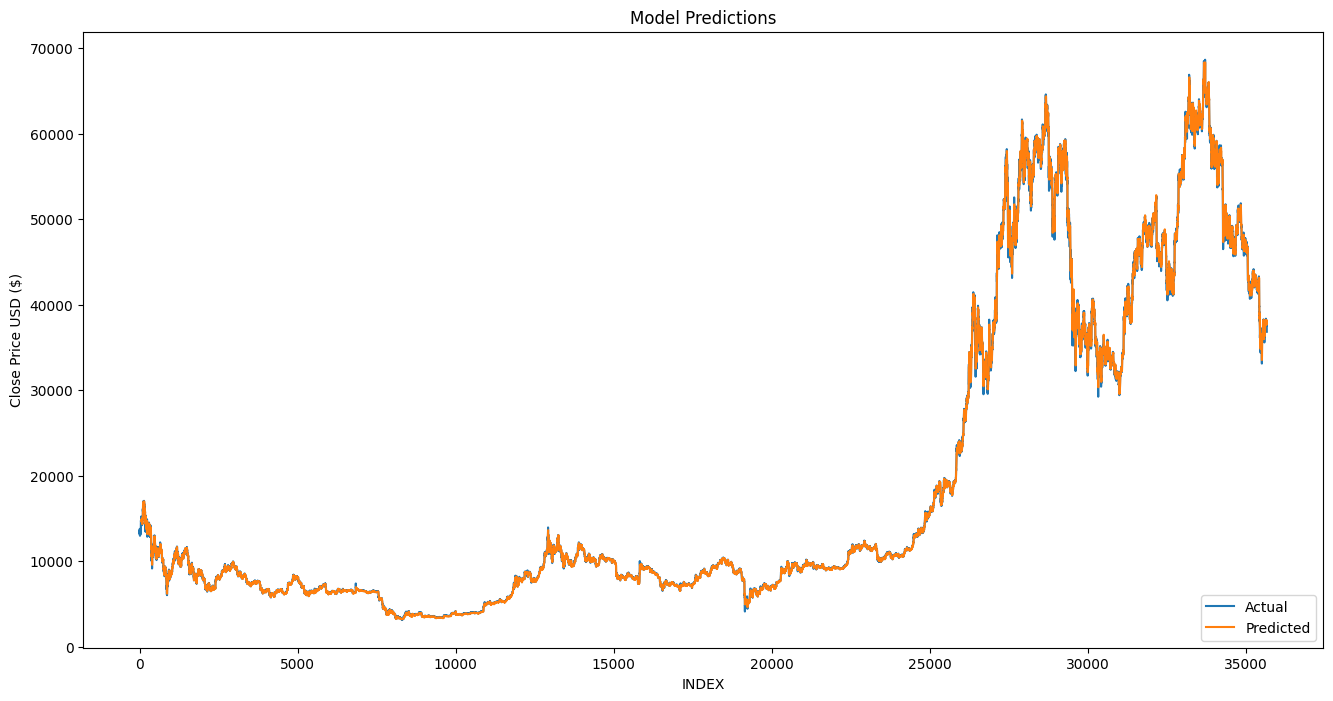

In [150]:
# Ploting the predictions
data['datetime'] = pd.to_datetime(data['datetime'], format='%d-%m-%Y %H:%M')
plt.figure(figsize=(16, 8))
plt.title('Model Predictions')
plt.xlabel('INDEX')
plt.ylabel('Close Price USD ($)')
plt.plot(data['close'])
plt.plot(range(60, len(data)), predictions, label='Predicted')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()


In [ ]:
# Simulate trading with slippage and compounding
initial_balance = 1000  # Initial balance
balance = initial_balance
wbalance=1000  #wallet balance
holdings = 0
current_position = 0
profits = [0]  # Initialize with initial balance value
total_closed_trades = 0
wins = 0
losses = 0
gross_profit = 0
gross_loss = 0
largest_winning_trade = 0
largest_losing_trade = 0
holding_duration = []
buy_and_hold_return = (valid['close'].iloc[-1] - valid['close'].iloc[0]) / valid['close'].iloc[0]
slippage_percentage = 0.15 / 100  # 0.15% slippage
#  threshold value (adjust as needed)
threshold = 0.02
signals = [0] * len(valid)

# Simulating trades and calculate metrics
for i in range(1, len(valid)-1):
    price = valid['close'].iloc[i]
    prediction = valid['Predictions'].iloc[i]
    previous_price = valid['close'].iloc[i - 1]
    nextprediction=valid['Predictions'].iloc[i+1]
    # Buy signal: predicted price is higher than previous close and above threshold
    if prediction > previous_price * (1 + threshold) and wbalance > 0 and current_position==0:
        holdings = wbalance / (previous_price * (1 + slippage_percentage))
        balance = 0
        current_position = 1
        entry_index = i  # Record entry index
        entry_price = price * (1 + slippage_percentage)  # Adjust entry price for slippage
        signals[i] = 1
    # Sell signal: predicted price is lower than previous close and above threshold
    elif ((prediction < previous_price) or (prediction < nextprediction))  and current_position == 1:
        balance = holdings * (price * (1 - slippage_percentage))  # Adjust sell price for slippage
        holdings = 0
        current_position = 0
        total_closed_trades += 1
        signals[i] = -1  # Set sell signal to -1

        # Calculate trade results with slippage charge
        trade_profit = balance - wbalance
        profits.append(balance)
        if trade_profit > 0:
            wins += 1
            gross_profit += trade_profit
            largest_winning_trade = max(largest_winning_trade, trade_profit)
            wbalance=wbalance+trade_profit
        else:
            losses += 1
            gross_loss += abs(trade_profit)
            largest_losing_trade = min(largest_losing_trade, trade_profit)
            wbalance=wbalance-trade_profit
        # Calculate holding duration
        holding_duration.append(i - entry_index)
# Add signals to the DataFrame using .loc
valid.loc[:, 'Signals'] = signals.copy()

# Save the DataFrame to a new CSV file named 'signals.csv'
valid.to_csv('signals.csv', index=False)


In [166]:
# Calculate metrics
net_profit = gross_profit - (slippage_percentage * total_closed_trades * initial_balance)
win_rate = (wins / total_closed_trades) * 100 if total_closed_trades > 0 else 0
max_drawdown = (max(profits) - net_profit) / max(profits) * 100
average_winning_trade = gross_profit / wins if wins > 0 else 0
average_losing_trade = gross_loss / losses if losses > 0 else 0
sharpe_ratio = np.sqrt(252) * (np.mean(profits) / np.std(profits))
sortino_ratio = np.sqrt(252) * (np.mean(profits) / np.std([x for x in profits if x < 0]))
average_holding_duration = np.mean(holding_duration) if holding_duration else 0
max_dip = min(profits) - initial_balance
average_dip = np.mean([x - initial_balance for x in profits])

In [167]:
# Print metrics
print(f"Net Profit: ${net_profit:.2f}")
print(f"Gross Profit: ${gross_profit:.2f}")
print(f"Total Closed Trades: {total_closed_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Max Drawdown: {max_drawdown:.2f}%")
print(f"Gross Loss: ${gross_loss:.2f}")
print(f"Average Winning Trade: ${average_winning_trade:.2f}")
print(f"Average Losing Trade: ${average_losing_trade:.2f}")
print(f"Buy and Hold Return of BTC: {buy_and_hold_return * 100:.2f}%")
print(f"Largest Losing Trade: ${largest_losing_trade:.2f}")
print(f"Largest Winning Trade: ${largest_winning_trade:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Average Holding Duration per Trade: {average_holding_duration:.2f} steps")
print(f"Average Dip in Running Trade: ${average_dip:.2f}")


Net Profit: $88067.76
Gross Profit: $88447.26
Total Closed Trades: 253
Win Rate: 58.10%
Max Drawdown: 47.08%
Gross Loss: $79485.13
Average Winning Trade: $601.68
Average Losing Trade: $749.86
Buy and Hold Return of BTC: 172.22%
Largest Losing Trade: $-8984.89
Largest Winning Trade: $5126.47
Sharpe Ratio: 13.03
Average Holding Duration per Trade: 3.11 steps
Average Dip in Running Trade: $32548.07


In [168]:
# Testing for out-of-sample dataset

# Load the out-of-sample dataset
out_of_sample_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kgpp/bitcoin2022.csv", names=headers)  # Update the path

# Create new data with only the "close" column for out-of-sample data
close_out_of_sample = out_of_sample_data.filter(["close"])
close_out_of_sample_array = close_out_of_sample.values

# Normalize the out-of-sample data using the same scaler used for training data
scaled_out_of_sample_data = scaler.transform(close_out_of_sample_array)

# Create the testing dataset for out-of-sample data
X_test_out_of_sample = []
for i in range(60, len(scaled_out_of_sample_data)):
    X_test_out_of_sample.append(scaled_out_of_sample_data[i - 60 : i, 0])

X_test_out_of_sample = np.array(X_test_out_of_sample)
X_test_out_of_sample = np.reshape(X_test_out_of_sample, (X_test_out_of_sample.shape[0], X_test_out_of_sample.shape[1], 1))

In [169]:
# Predict with the trained LSTM model for out-of-sample data
predictions_out_of_sample = model.predict(X_test_out_of_sample)
predictions_out_of_sample = scaler.inverse_transform(predictions_out_of_sample)

# Create a dataframe for plotting
plot_data_out_of_sample = close_out_of_sample.copy()
plot_data_out_of_sample["Predictions"] = np.nan
plot_data_out_of_sample["Predictions"].iloc[-predictions_out_of_sample.shape[0]:] = predictions_out_of_sample.flatten()

272/272 [==============================] - 0s 1ms/step


In [170]:
# Convert the 'datetime' column to datetime format with the correct format
out_of_sample_data['datetime'] = pd.to_datetime(out_of_sample_data['datetime'], format='%d/%m/%Y %H:%M')


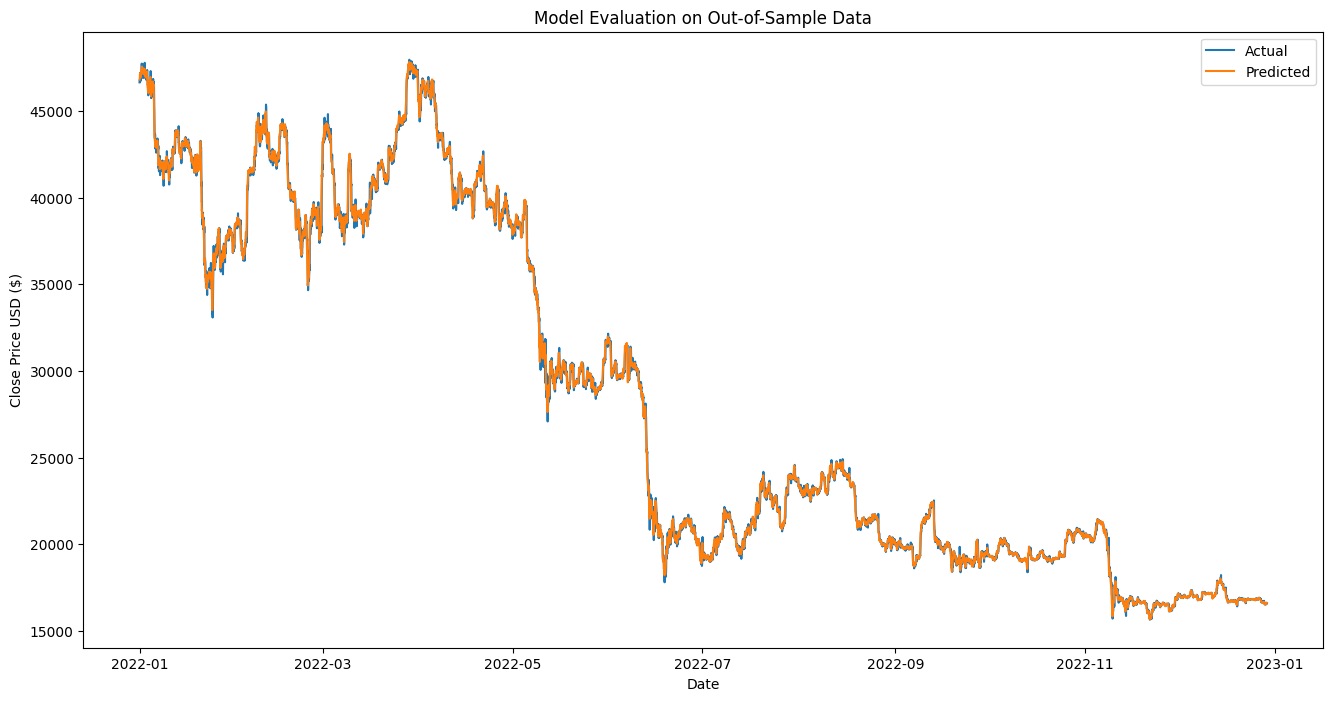

In [171]:
# Ploting the original and predicted values for out-of-sample data
plt.figure(figsize=(16, 8))
plt.title('Model Evaluation on Out-of-Sample Data')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

# Adjusting the indexing and use the 'datetime' column for the x-axis
dates = out_of_sample_data['datetime'][60:]
actual_prices = out_of_sample_data['close'][60:]

plt.plot(dates, actual_prices, label='Actual')
plt.plot(dates, predictions_out_of_sample, label='Predicted')
plt.legend()
plt.show()

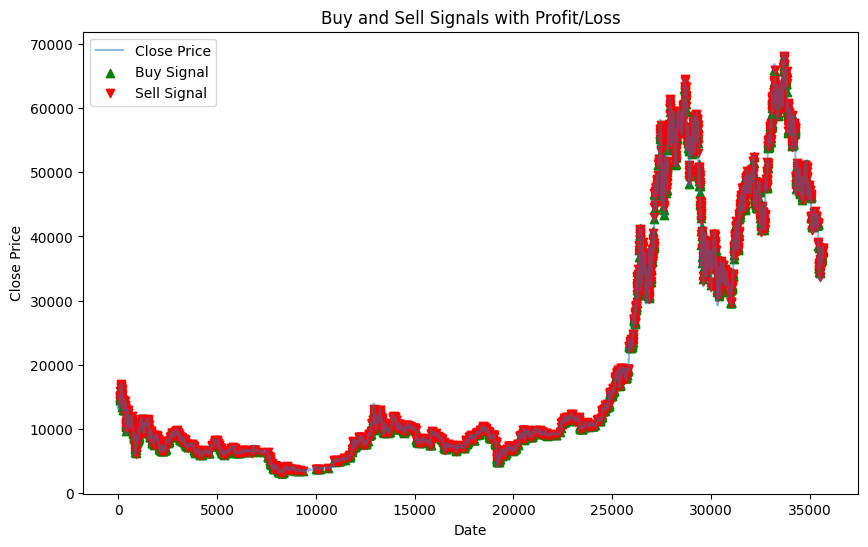

Total Profit in complete dataset: 124204.24
Profit percentage : 12420.42%


In [158]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV file
file_path = "/content/signals.csv"
df = pd.read_csv(file_path)

# Initialize variables for total profit and total loss
total_profit = 0
total_loss = 0

# Create a column to store profits/losses
df['Profit_Loss'] = 0.0

# Iterate through the DataFrame to calculate profits and losses
for i in range(1, len(df)):
    if df['Signals'].iloc[i] == -1:  # Sell signal
        if df['Signals'].iloc[i - 1] == 1:  # Corresponding buy signal
            profit_loss = df['close'].iloc[i] - df['close'].iloc[i - 1]
            df.at[i, 'Profit_Loss'] = profit_loss

            # Update total profit or total loss
            if profit_loss > 0:
                total_profit += profit_loss
            else:
                total_loss += abs(profit_loss)

# Plotting 1 and -1 signals with profits/losses
plt.figure(figsize=(10, 6))
plt.plot(df['close'], label='Close Price', alpha=0.5)

buy_signals = df[df['Signals'] == 1]
sell_signals = df[df['Signals'] == -1]

# Plot Buy signals
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', label='Buy Signal')

# Plot Sell signals with profits/losses
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', label='Sell Signal')


plt.title('Buy and Sell Signals with Profit/Loss')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Display total profit and total loss
total_profit=total_profit-total_loss
print(f'Total Profit in complete dataset: {total_profit:.2f}')
prp=(total_profit/initial_balance)*100
print(f"Profit percentage : {prp:.2f}%")
